# Predicting Premier League Match Winners From Game Data


### Project Goal
In this project we will be using post match data from premier league matches and predicting which team won the game so that coaches can understand from looking at post match data whether they 'deserved' to win the game or not. Using K-nearest neighbour, logistic regression and random forest classifier classification models we will see which models perform best and compare their results.

### Introduction
The premier league is considered the most competitive football league in the world. Nielsen research found that 3.2 billion people watched Premier League football during the 2018/19 campaign (1) and the evaluation of all premier league clubs combined being  18.7 billion pounds in total (2).


sources:
- (1) https://www.sportingindex.com/spread-betting-blog/premier-league-viewing-figures
- (2) https://sqaf.club/premier-league-club-valuations/


### Data Source
https://github.com/dataquestio/project-walkthroughs/blob/master/football_matches/matches.csv


### Conclusion
**See full conclusion at bottom of project**

We found that the **random forest classifier** performed the best on our data, with a **CV score of 0.692** and a **test accuracy score of 0.728**. This means that this model can correctly predict the winner of a football match by seeing the post match stats roughly 73% of the time.

Below is the confusion matrix for our random forest classifier.

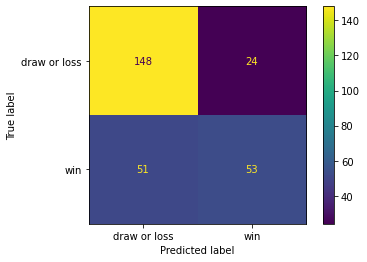

---
---

# 1. Getting Familiar With the Data

Columns descriptions:
- `date`: date the game was played
- `time`: time the game was played
- `comp`: the competition (premier league)
- `round`: the gameweek
- `day`: the day of the week the game was played
- `venue`: either 'home' or 'away'
- `result`: either win, loss or draw
- `gf`: how many goals the team scored
- `ga`: how mant goals the opponent scored
- `opponent`: which team was the opponent
- `xg`: the team's number of expected goals
- `xga`: the opponent's number of expected goals
- `poss`: the team's possession
- `attendance`: the total game attendance
- `captain`: the team's captain
- `formation`: the team's formation
- `referee`: the game's referee
- `match report`: the match report
- `notes`: notes on the match
- `sh`: the team's number of shots
- `sot`: the team's number of shots on target
- `dist`: average shot distance in yards, not including penalties
- `fk`: shots from free kicks
- `pk`: the number of penalties converted
- `pkatt`: the number of penalties awarded
- `season`: which season the match was in
- `team`: the team

In [652]:
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [653]:
# Reading in the data
matches = pd.read_csv("matches.csv", index_col=0)

In [654]:
# Looking at the first few rows of the dataset
pd.set_option('display.max_columns', None)
print(f'There are {matches.shape[0]} rows (or number of games) and {matches.shape[1]} columns in the dataset')
matches.head()

There are 1389 rows (or number of games) and 27 columns in the dataset


,date,time,comp,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,1.9,1.3,64.0,58262.0,Fernandinho,4-3-3,Anthony Taylor,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,2.7,0.1,67.0,51437.0,İlkay Gündoğan,4-3-3,Graham Scott,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,3.8,0.1,80.0,52276.0,İlkay Gündoğan,4-3-3,Martin Atkinson,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,2.9,0.8,61.0,32087.0,İlkay Gündoğan,4-3-3,Paul Tierney,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,1.1,0.4,63.0,52698.0,Fernandinho,4-3-3,Jonathan Moss,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City


Observations:
- Can see columns which may be redundant: `comp`, `match report`, `notes`
- The dataset is quite small, with only 1389 rows.
    - Should think about getting more data from different premier league seasons, or maybe using data from other leagues.

Lets have a closer look at these columns

In [655]:
# checking different values and their frequencies for the `comp`, `match report` and `notes` columns
print(matches['comp'].value_counts())
print('_'*30)
print(matches['match report'].value_counts())
print('_'*30)
print(matches['notes'].value_counts(dropna=False))

Premier League    1389
Name: comp, dtype: int64
______________________________
Match Report    1389
Name: match report, dtype: int64
______________________________
NaN    1389
Name: notes, dtype: int64


I will remove all these features as every row contains the same information they are all redundant.

In [656]:
# Dropping the columns that have the same value for every row
matches = matches.drop(['comp', 'match report', 'notes'], axis=1)

In [657]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 1 to 42
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1389 non-null   object 
 1   time        1389 non-null   object 
 2   round       1389 non-null   object 
 3   day         1389 non-null   object 
 4   venue       1389 non-null   object 
 5   result      1389 non-null   object 
 6   gf          1389 non-null   float64
 7   ga          1389 non-null   float64
 8   opponent    1389 non-null   object 
 9   xg          1389 non-null   float64
 10  xga         1389 non-null   float64
 11  poss        1389 non-null   float64
 12  attendance  693 non-null    float64
 13  captain     1389 non-null   object 
 14  formation   1389 non-null   object 
 15  referee     1389 non-null   object 
 16  sh          1389 non-null   float64
 17  sot         1389 non-null   float64
 18  dist        1388 non-null   float64
 19  fk          1389 non-null   f

Observations:
- The `date` column is stored as a string (we will convert to datetime)
- The only column with missing values is the `attendance` column.
- The dataset contains 12 categorical variables and 12 numerical variables. (`season` is stored as 'int64' but is a categorical variable.) 

lets change the datatype for the `season` column to reflect that it is a categorical variable and change the `date` column to datetime.

Changing the `date` column to a datetime type allows us to then split the data into our train and test splits, so that the test set is the most recent subset of the data.

In [658]:
# Changing the datatype for the `date` column to datetime
matches['date'] = pd.to_datetime(matches['date'])

# Adding the `win` column which will be the target variable
matches['win'] = matches['result'].apply(lambda x: 1 if x=='W' else 0)

# Creating test and train sets to be used later for our models
train = matches[matches['date'] < '2022-01-01'].copy()
test = matches[matches['date'] > '2022-01-01'].copy()

# Index to know which dataset each row belongs to
train['train'] = 1
test['train'] = 0

# rejoining the train and test sets with an index to show which set each row is a part of
all_data = pd.concat([train, test])

# Printing the percentage of the total dataset that is in the test set
print(f'The test set is {test.shape[0]/train.shape[0] * 100} percent of the overall data')

The test set is 24.932249322493224 percent of the overall data


Now we have seen the entire dataset and split it into test and train sets, we can begin the exploratory data analysis on the train set.

## 2. Exploratory Data Analysis

### 2.1 Categorical variables


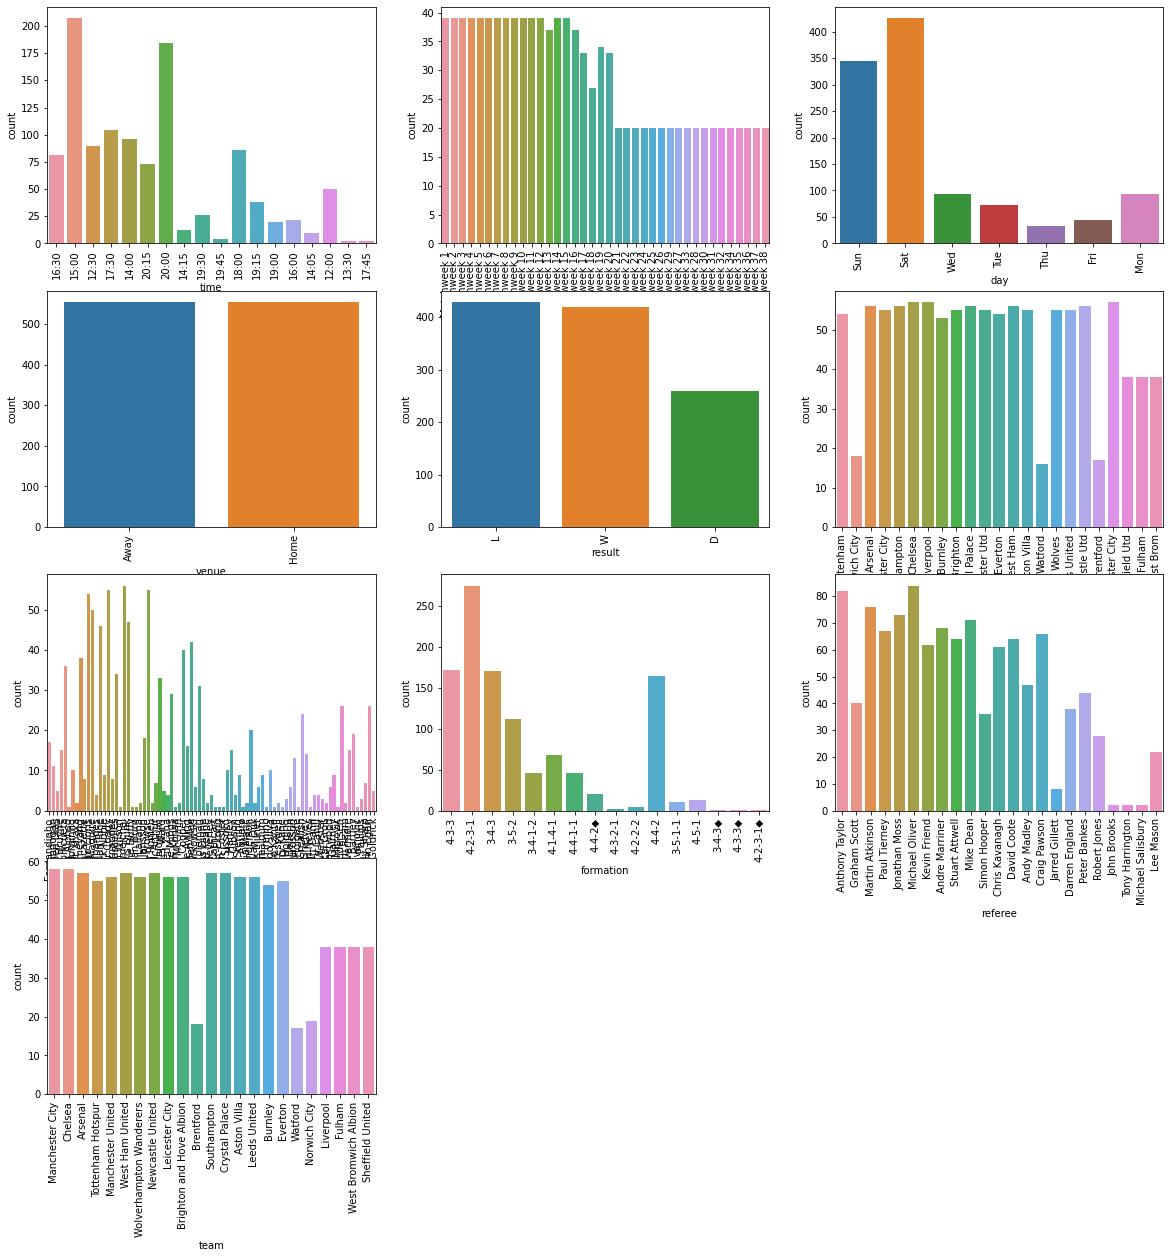

In [663]:
# Creating a list containing the names of the categorical columns
cat_cols = train.select_dtypes(include=['object']).columns

# Plotting bar charts for categorical columns on the same figure
fig = plt.figure(figsize=(20,20))
for ind, col in enumerate(cat_cols):
    ax = plt.subplot(4,3,ind+1)
    sns.countplot(x=train[col], ax=ax)
    plt.xticks(rotation=90)

Observations:
- Can see a gap for the summer break in the `date` plot.
- some missing data for the `round` column needs to be explored, perhaps delayed games that hadn't been played by the time the data was scraped are causing this.
- Games are most commonly played on a Saturday or Sunday.
- There is a difference in the number of losses and wins in the dataset. This is strange as if one team wins, another has to lose. Should investigate this further.
- About a third of games end in draws.
- There are a couple more popular formations than the rest. (could turn less popular formations into 'other' category to reduce number of options in this column.
- The 2022 season is less represented in the dataset by 131 games (this is due to when the dataset was scraped).
- Some teams have roughly half the number of games in the dataset (this could be due to promotion/relegation or missing data).

Lets first look into the columns that may be effected my missing data or that raise questions, before then selecting a narrower range of categorical features and looking at if they seem to have any relation to winning or not.

Things to investigate:
1. Is every fixture in the dataset twice, from both teams 'perspective'?
2. Why does `round` column have missing data?
3. Why is there a difference between the number of wins and the number of losses in the dataset?
4. What are the most popular formations?

---
1. Is every fixture in the dataset twice, from both teams 'perspective'?
    - There are (10 x 38) games in a season

In [415]:
# Calculating number of games per season
games_a_season = 10 * 38
print(f'There are {games_a_season} games every season')

# Looking at how many rows in the dataset correspond to each season
print(train['season'].value_counts())

There are 380 games every season
2021    760
2022    347
Name: season, dtype: int64


Answer: Looks like every fixture is in the dataset twice, and can see we are missing more than half the season of data for the 2022 season.

We won't take the time to remove the repeated matches because the added rows won't either hinder or add to the model, however the dataset is small so the effect on processing time is not significant.


2. Why does round column have missing data?

In [416]:
# Looking at the frequencies for each matchweek to be in the dataset
train['round'].value_counts()

Matchweek 1     39
Matchweek 8     39
Matchweek 15    39
Matchweek 14    39
Matchweek 12    39
Matchweek 11    39
Matchweek 10    39
Matchweek 9     39
Matchweek 7     39
Matchweek 6     39
Matchweek 5     39
Matchweek 4     39
Matchweek 3     39
Matchweek 2     39
Matchweek 13    37
Matchweek 16    37
Matchweek 19    34
Matchweek 20    33
Matchweek 17    33
Matchweek 18    27
Matchweek 37    20
Matchweek 36    20
Matchweek 35    20
Matchweek 34    20
Matchweek 32    20
Matchweek 31    20
Matchweek 30    20
Matchweek 28    20
Matchweek 33    20
Matchweek 27    20
Matchweek 29    20
Matchweek 26    20
Matchweek 25    20
Matchweek 24    20
Matchweek 23    20
Matchweek 22    20
Matchweek 21    20
Matchweek 38    20
Name: round, dtype: int64

Looks like there is missing data for the matchweeks, Let's look at the value counts for the different teams to see if we can explain this.

In [417]:
# Looking at the frequencies for each team in the dataset
train['team'].value_counts()

Manchester City             58
Chelsea                     58
West Ham United             57
Crystal Palace              57
Newcastle United            57
Southampton                 57
Arsenal                     57
Wolverhampton Wanderers     56
Manchester United           56
Aston Villa                 56
Leeds United                56
Brighton and Hove Albion    56
Leicester City              56
Tottenham Hotspur           55
Everton                     55
Burnley                     54
Liverpool                   38
Fulham                      38
West Bromwich Albion        38
Sheffield United            38
Norwich City                19
Brentford                   18
Watford                     17
Name: team, dtype: int64

From looking at the value counts for the different teams and using some knowledge about how the premier league works we can see that:
- The majority of teams have over 55 games in the dataset. These are teams which were in the premier league for two season.
- The rest of the teams were either promoted or relegated from the premier league at the end of the 2021 season.
    - Anomaly here as Liverpool were not relegated but have number of games in dataset to suggest that they were?
- The varying number of games played for each team is due to the data being scraped midway through the 2022 season.

Lets investigate Liverpool's missing data

In [418]:
# Investigating the data for liverpool
train[train['team'] == 'Liverpool'].season.value_counts()

2021    38
Name: season, dtype: int64

We can see that Livepool only have data for the 2021 season, therefore we can conclude that we are missing data for them in the 2022 season.

--- 

3. Why is there a difference between the number of wins and the number of losses in the dataset?

This can now be explained by the fact that we have 2 rows for every match in the dataset, one from each team's 'perspective' and because we are missing data from Liverpool in the 2022 season. Therefore the number of wins and losses in the dataset no longer match (example: if Arsenal beat liverpool in 2022 and registered a win in the dataset, there would be no row registering liverpool's perspective of a loss to match that row).

---

4. What are the most popular formations?


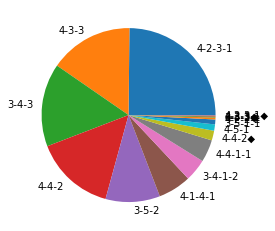

In [419]:
# Plotting a pie chart to look at the different formations used and their frequencies
plt.pie(train['formation'].value_counts(),labels=train['formation'].value_counts().index)
plt.show()

Answer: We can see that the most common formations are 4231, 433, 343 and 442.

Now that we have investigated those points we can move onto looking at some of the more relevant categorical variables and seeing if they appear to have any relation to the `win` column.

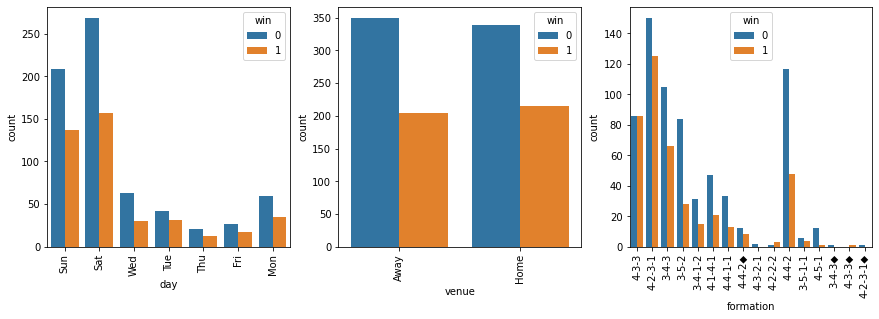

In [420]:
# Creating a lost for a subset of categorical columns to be explored further
cat_cols_subset = ['day', 'venue', 'formation']

# Plotting bar graphs for the subset of categorical columns and comparing them with the `win` column
fig = plt.figure(figsize=(20,15))
for ind, col in enumerate(cat_cols_subset):
    ax = plt.subplot(3,4,ind+1)
    sns.countplot(x=train[col], ax=ax, hue=train['win'])
    plt.xticks(rotation=90)
    

Observations:
- We can see that the home team is more likely to win than the away team
- Some formations appear to have a significantly higher win percentage (could be down to a good team using this formation, therefore using this feature could introduce collinearity)

### 2.2 Numerical Variables

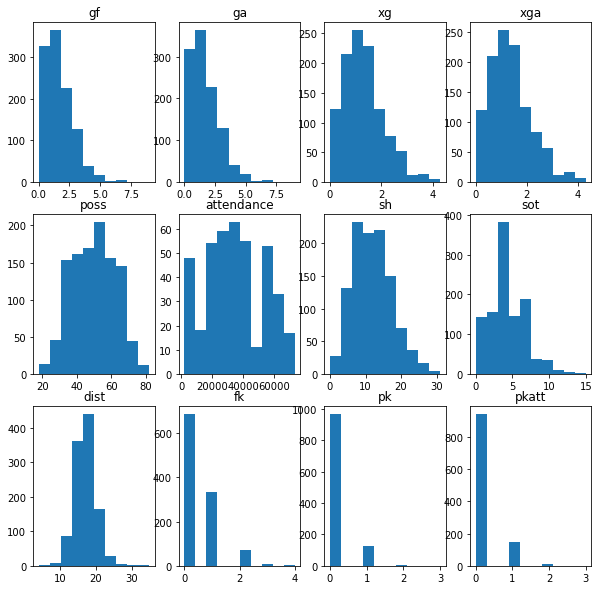

In [421]:
# Selecting all columns with float data type
num_cols = train.select_dtypes(include=['float64']).columns

# Plotting histograms for numerical features on the same figure
fig = plt.figure(figsize=(10,10))
for ind, col in enumerate(num_cols):
    ax=plt.subplot(3,4,ind+1)
    plt.hist(train[col])
    plt.title(col)

Observations:
- Everything looks normally distributed
- `gf`, `ga`, `xgf`, `xga` are all rightly skewed. As are `fk`, `pk`, `pkatt`

<function matplotlib.pyplot.show(close=None, block=None)>

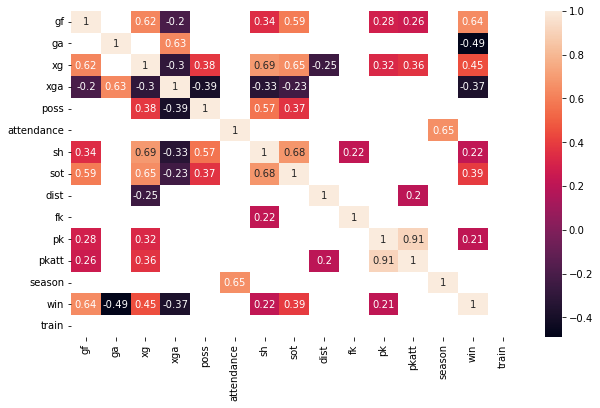

In [422]:
# Plotting a heatmap to look at correlations between the variables
correlations = train.corr()
fig = plt.figure(figsize=(10,6))
ax = sns.heatmap(correlations[abs(correlations) > 0.2], annot=True)
plt.show

Some things we can see from the heatmap above:
- `Win` has high absolute correlation with: `gf`, `ga`, `xg`, `xga`, `sh`, `sot`, `pk`.
- We see lots of correlations within different features. For example: `sh`, `sot` or `pk`, `pkatt`. We will have to think about how to deal with these features that are highly correlated.
- `xg` has a high correlation with `win` but also high correlation with lots of the variables that are also correlated with `win`. This makes intuitive sense and `xg` is a stat which tracks 'expected goals'. This is a constructed statistic, so it is necessarily contingent on other post match stats for example `pk` therefore using the `xg` stat may introduce collinearilty into the model.

## 3. Feature Selection

Now we will choose some features that we will use to build our baseline model.

Based of my intuition for the problem and the EDA performed above, for now we will use:
-`venue`, `opponent`, `formation`, `sot`, `pk`, `team` as our features and our target variable is the `win` column.


In [475]:
# Selecting features we will use as predictors for our first model
features = ['xg', 'xga', 'venue', 'opponent', 'formation', 'sot', 'pk', 'team', 'train', 'win']

features_1 = ['sot', 'train', 'win']

all_data_subset = all_data[features]

## 4. Feature Engineering

For now I am just going to leave the features as they are to see how they work in a baseline model


## 5. Data Preprocessing

Lets preprocess the data to get it ready to be used in our model.

In [476]:
# Creating dummy variables for categorical features
all_data_dummies = pd.get_dummies(all_data_subset, columns=['venue', 'opponent', 'formation', 'team'], drop_first=True)
#all_data_dummies = all_data_subset.copy()

In [477]:
# Splitting the data back into a train and test set
train = all_data_dummies[all_data_dummies['train'] == 1]
test = all_data_dummies[all_data_dummies['train'] == 0]

# Defining the X and y data ready for the model from the training data
y_train = train['win']
X_train = train.drop(['train', 'win'], axis=1)

# Defining the X and y data ready for the model from the test data
y_test = test['win']
X_test = test.drop(['train', 'win'], axis=1)

In [478]:
# Importing a scaler
from sklearn.preprocessing import StandardScaler

# Defining the scaler
scaler = StandardScaler()

# Fitting the scaler to the X_train data then transforming both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 6. Model Building

For this classification problem, we will use different models and compare their results. We will use a K-nearest neighbors classifier, a decision tree classifier and a logistic regression classifier. We will test their performance over cross validation sets and then test their performance on a final test set and compile the results.

### 6.1 K-Nearest Neighbours

In [555]:
# Importing cross validation, accuracy score and gridsearch
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [556]:
# Finding the optimal number of neighbours for K nearest neighbours

# Empty list to contain the CV scores
knn_cv_scores = []

# Calling the model with a range of neighbour values and appending the mean CV score to a list
for i  in range(1,50):
    knn_ksearch = KNeighborsClassifier(n_neighbors=i)
    knn_cv = cross_val_score(knn_ksearch, X_train_scaled, y_train).mean()
    knn_cv_scores.append(knn_cv)

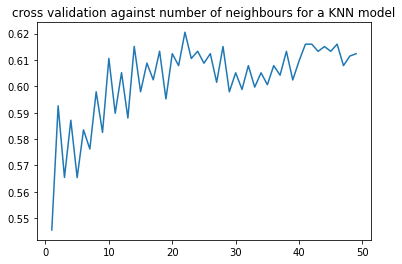

In [557]:
# Plotting how mean CV score vaires with number of neighbours
plt.title("cross validation against number of neighbours for a KNN model")
plt.plot(range(1,50), knn_cv_scores)
plt.show()

From the above plot we can see that choosing 10 as the number of neighbours will maximise the CV score and be less likely to lead to overfitting.

In [558]:
# Importing a K nearest neighbours classifier
from sklearn.neighbors import KNeighborsClassifier

# Calling the model with 10 neighbours and finding the mean cv score
knn = KNeighborsClassifier(n_neighbors=24)
knn_cv = round(cross_val_score(knn, X_train_scaled, y_train).mean(), 3)

# Fitting the model and making a prediction
knn_model = knn.fit(X_train_scaled, y_train)
knn_prediction = knn_model.predict(X_test_scaled)

# Finding the accuracy score for the predictions made
knn_test_score = round(accuracy_score(y_test, knn_prediction), 3)

print(f'for the KNN model the mean CV score was: {knn_cv} and the test accuracy score was {knn_test_score}')

for the KNN model the mean CV score was: 0.613 and the test accuracy score was 0.674


### 6.2 Logistic Regression

In [593]:
# Hyperparameter tuning using grid search

# Instantiating the model
lr = LogisticRegression()

# Defining the params to search over
params = {
    "C":np.logspace(-3,3,7),
    "penalty":["l2"]
}

# Performing grid search on the train data and printing the best parameters
lr_grid = GridSearchCV(estimator=lr, param_grid=params)
lr_grid.fit(X_train_scaled, y_train)
print(lr_grid.best_params_)

{'C': 0.01, 'penalty': 'l2'}


In [594]:
# Importing a logistic regression classifier
from sklearn.linear_model import LogisticRegression

# Using the model with hyperparameters found from gridsearch to get a mean cross val score
lr = lr_grid.best_estimator_
lr_cv = round(cross_val_score(lr, X_train_scaled, y_train).mean(), 3)

In [595]:
# Fitting the logistic regression model and making a prediction on the test set
lr_model = lr.fit(X_train_scaled, y_train)
lr_prediction = lr_model.predict(X_test_scaled)

# Finding the accuracy score for logistic regression model on the test set
lr_test_score = round(accuracy_score(y_test, lr_prediction), 3)

In [596]:
print(f'for the logistic regression model the mean CV score was: {lr_cv} and the test accuracy score was {lr_test_score}')

for the logistic regression model the mean CV score was: 0.678 and the test accuracy score was 0.725


### 6.3 Random Forest Classifier

In [610]:
# Hyperparameter tuning using grid search

# Instantiating the model
rfc = RandomForestClassifier()

# Defining the params to search over
params = {
    "max_depth": [2,8,16],
    "n_estimators": [64, 128, 256]
}

# Performing grid search on the train data and printing the best parameters
rfc_grid = GridSearchCV(estimator=rfc, param_grid=params)
rfc_grid.fit(X_train_scaled, y_train)
print(rfc_grid.best_params_)

{'max_depth': 8, 'n_estimators': 256}


In [617]:
# Importing the random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Calling the random forest classifier and finding the mean cv score
rfc = rfc_grid.best_estimator_
rfc_cv = round(cross_val_score(rfc, X_train_scaled, y_train).mean(), 3)

In [627]:
# Fitting the random forest classifier model and making a prediction on the test set

# Emtply list to store different accuracy scores on test set
rfc_test_scores = []

# Adding 5 different test scores for random forest classifier to then find an average
for i in range(1,6):
    rfc_model = rfc.fit(X_train_scaled, y_train)
    rfc_prediction = rfc_model.predict(X_test_scaled)
    rfc_test_score = round(accuracy_score(y_test, rfc_prediction), 3)
    rfc_test_scores.append(rfc_test_score)


# Finding the mean accuracy score for the random forest classifier on the test set
rfc_test_score_mean = np.mean(rfc_test_scores)

In [629]:
print(f'for the random forest classifier model the mean CV score was: {rfc_cv} and the mean test accuracy score was {rfc_test_score_mean}')

for the random forest classifier model the mean CV score was: 0.692 and the mean test accuracy score was 0.7282


### 6.3.1 Random Forest Classifier Confusion Matrix

Lets take a look at how our random forest classifier is doing with its classifications.

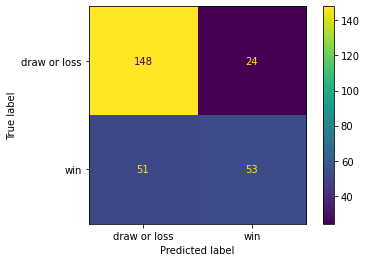

In [650]:
# Importing confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Making the confusion matrix
rfc_confusion_matrix = confusion_matrix(y_test, rfc_prediction)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = rfc_confusion_matrix, display_labels = ['draw or loss', 'win'])
cm_display.plot()
plt.show()

Here we can see that our model in general performs well. However we can see that it is worse at predicting draws or losses that were actually wins than it is at predicting wins that were actually draws or losses.

### 7. Conclusion

In [630]:
# Creating a dataframe to summarise the results
summary_table = pd.DataFrame({'K-Nearest Neighbours': (knn_cv, knn_test_score),
                              'Logistic Regression': (lr_cv, lr_test_score),
                              'Random Forest Classifier': (rfc_cv, rfc_test_score_mean)
                             }, index=('CV score','Test Accuracy Score'))

In [631]:
summary_table

,K-Nearest Neighbours,Logistic Regression,Random Forest Classifier
CV score,0.613,0.678,0.6920
Test Accuracy Score,0.674,0.725,0.7282


Above we can see a table showing the results for all our models. We can see that the **random forest classifier** performed the best on our data, with a **CV score of 0.692** and a **test accuracy score of 0.728**. This means that this model can correctly predict the winner of a football match by seeing the post match stats roughly 73% of the time.

In the matches were our model predicts that the team won the game, it is saying that 'normally' if the team played this well and had these post match stats it means it probably won the game. Therefore to not have won the game is in some sense unlucky. Perhaps this type of model could help coaches understand when their team performed well and had a strong performance statistically but failed to win the game.

This project has shown that from looking solely at the post match stats it is possible to have a very good guess at which team won the game. Whilst this can't help any football fans to 'beat the bookies' it does support a football fans intuition that sometimes a team is hard done by and perhaps 'deserved' to win the game.

## Improvements to project
- Add more data (could be premier league other season, or from different leagues) or test the model on new data
- Do some feature anaylsis to see which features are most correlated with winning performances

## Future developments of project
- Add more features and more data to the model. Scrape new data for recent games and predict on them, have the model then feedback what changes in the stats would have most likely helped a team to win (for example, gave away too many free kicks that resulted in a shot, therefore conceded too many goals) therefore using the model to give actionable insights for football coaches.
